In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from data import read_preprocessed_data
from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import PCA
import seaborn as sns

color_palette = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]

data_scaled = read_preprocessed_data(gmm=True)

c:\Users\Noka9\Desktop\customer-profile-analysis\data/marketing_campaign.csv


In [2]:
 #model mieszanin gaussa

gmm = GaussianMixture(
    # Stosujemy model mieszanin gaussa dla wybranej liczby klastrów
    n_components=3,          
    covariance_type='tied',  
    # Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
    random_state=42
)
data_scaled['Cluster'] = gmm.fit_predict(data_scaled)

Text(0.5, 1.0, 'Metoda GMM dla trzech klastrów z wizualizacją PCA ')

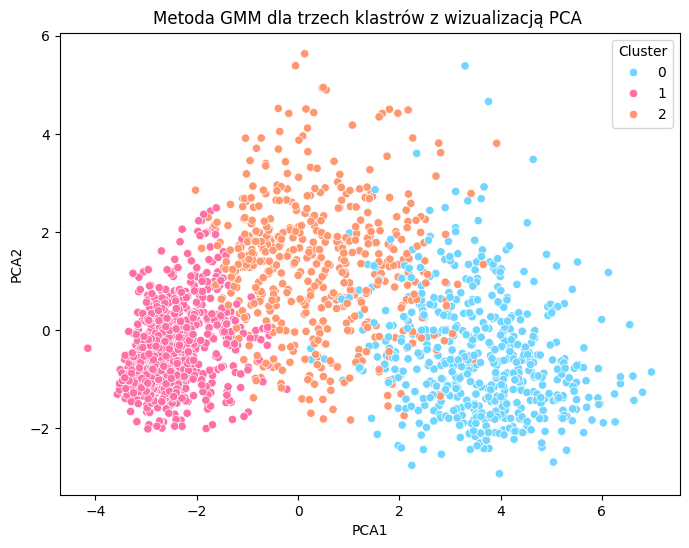

In [3]:
# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
color_palette = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_palette[:-1]
)
plt.title("Metoda GMM dla trzech klastrów z wizualizacją PCA ")

In [4]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False,gmm=True)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster


#Dla łatwiejszej analizy wydatków zliczamy procent przychodów jaki stanowią wydatki (pozwala identyfikować rozrzutnych klientów)
original_data["Spending_To_Income_Ratio"] = original_data["Spent"]/original_data["Income"]
cluster_summary["Spending_To_Income_Ratio_Mode"] = original_data.groupby("Cluster")["Spending_To_Income_Ratio"].agg(lambda x: x.mode()[0])

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()
# Podsumowanie klastrów

kl1 = cluster_summary.iloc[1].values.tolist()
cluster_summary.transpose()

c:\Users\Noka9\Desktop\customer-profile-analysis\data/marketing_campaign.csv


Cluster,0,1,2
Income,73345.076797,33777.794027,56974.158559
Kidhome,0.073529,0.813594,0.241441
Teenhome,0.300654,0.449022,0.854054
Recency,49.589869,49.041195,48.385586
MntWines,555.383987,37.812564,429.43964
MntFruits,52.656863,4.559217,16.253153
MntMeatProducts,375.381944,21.313079,109.245045
MntFishProducts,83.155229,6.179197,20.551351
MntSweetProducts,54.228758,4.502575,15.837838
MntGoldProds,66.101307,14.365602,52.82973


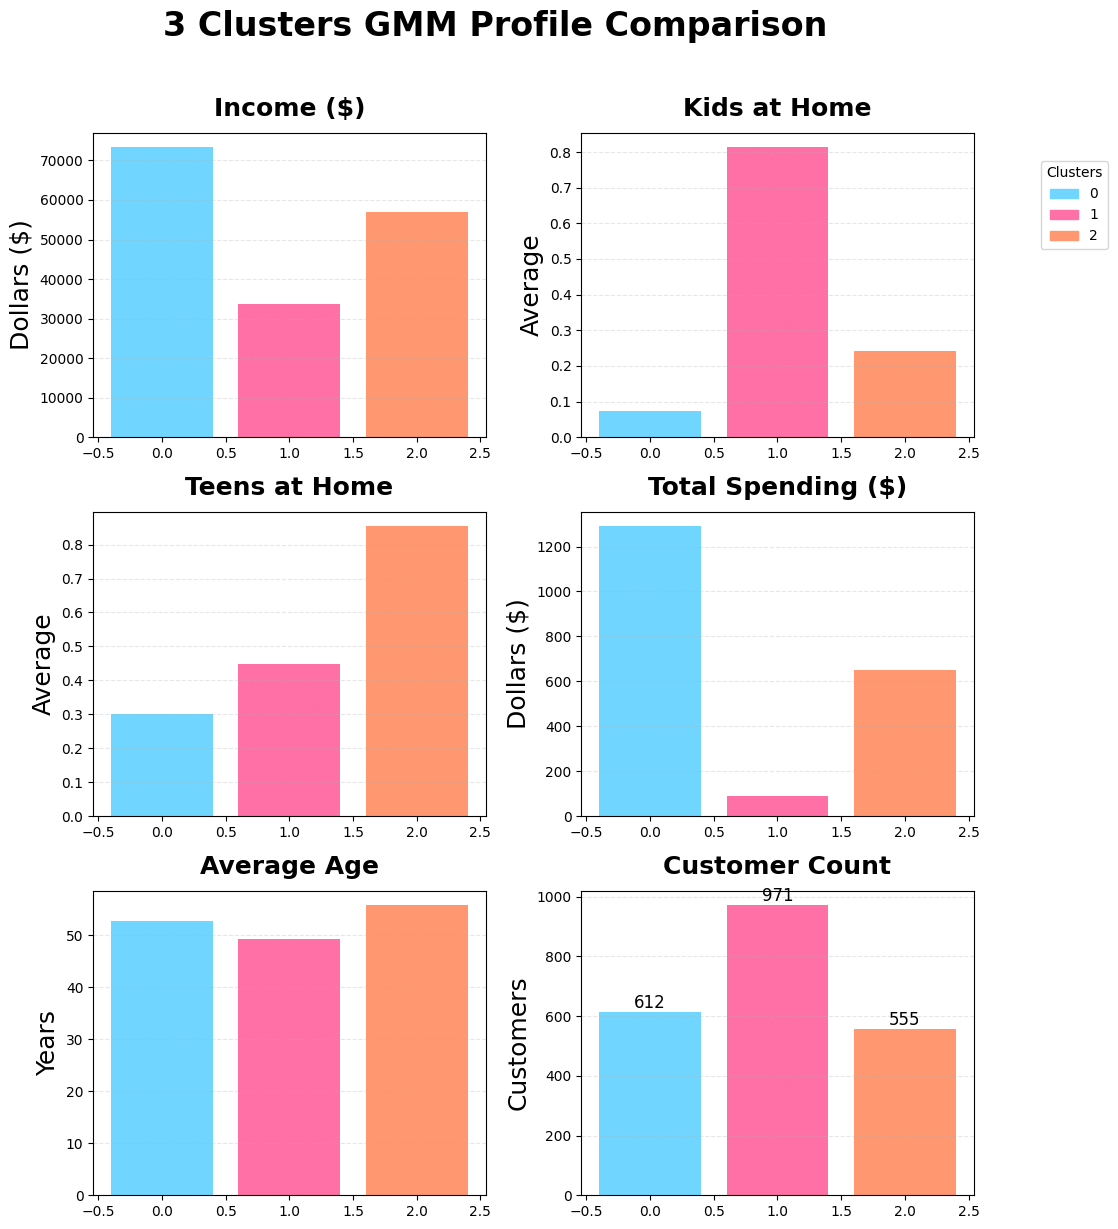

In [5]:
# Data preparation
variables = ['Income', 'Kidhome', 'Teenhome', 'Spent', 'Age', 'Count']
titles = ['Income ($)', 'Kids at Home', 'Teens at Home', 'Total Spending ($)', 'Average Age', 'Customer Count']
cluster_labels = cluster_summary.index

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle('3 Clusters GMM Profile Comparison', fontsize=24, y=1.02, weight='bold')

# Plot each variable
for ax, var, title in zip(axes.flatten(), variables, titles):
    values = cluster_summary[var]
    
    bars = ax.bar(cluster_labels, values, color=color_palette)
    ax.set_title(title, pad=12, weight='bold', fontsize=18)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add value labels for Count
    if var == 'Count':
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=12)
    
    # Format y-axis for monetary values
    if var in ['Income', 'Spent']:
        ax.set_ylabel('Dollars ($)', fontsize=18)
    elif var == 'Age':
        ax.set_ylabel('Years', fontsize=18)
    elif var == 'Count':
        ax.set_ylabel('Customers', fontsize=18)
    else:
        ax.set_ylabel('Average', fontsize=18)

plt.tight_layout()

# Add legend once
handles = [plt.Rectangle((0,0),1,1, color=color) 
           for color in color_palette]
fig.legend(handles, cluster_labels, 
           title='Clusters', 
           loc='upper right', 
           bbox_to_anchor=(1.12, 0.9))

plt.show()

In [6]:
 #model mieszanin gaussa
data_scaled = read_preprocessed_data(gmm=True)
gmm = GaussianMixture(
    # Stosujemy model mieszanin gaussa dla wybranej liczby klastrów
    n_components=4,          
    covariance_type='tied',  
    # Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
    random_state=42
)
data_scaled['Cluster'] = gmm.fit_predict(data_scaled)

c:\Users\Noka9\Desktop\customer-profile-analysis\data/marketing_campaign.csv


Text(0.5, 1.0, 'Metoda GMM dla czterech klastrów z wizualizacją PCA ')

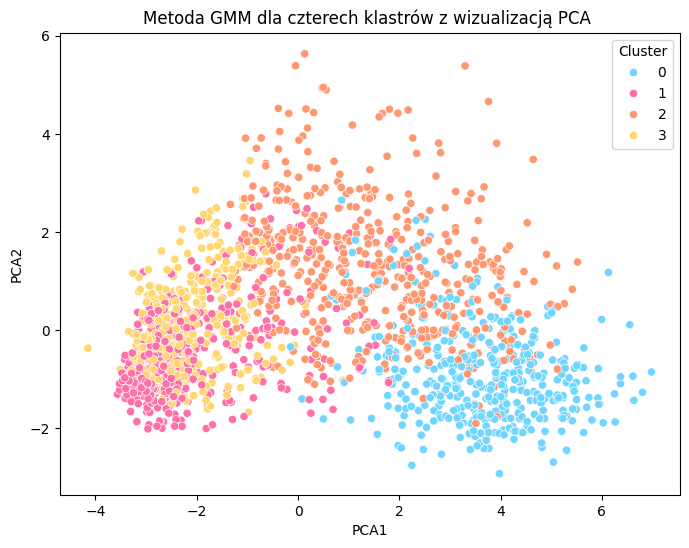

In [7]:
# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
color_palette = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_palette
)
plt.title("Metoda GMM dla czterech klastrów z wizualizacją PCA ")

In [8]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster


#Dla łatwiejszej analizy wydatków zliczamy procent przychodów jaki stanowią wydatki (pozwala identyfikować rozrzutnych klientów)
original_data["Spending_To_Income_Ratio"] = original_data["Spent"]/original_data["Income"]
cluster_summary["Spending_To_Income_Ratio_Mode"] = original_data.groupby("Cluster")["Spending_To_Income_Ratio"].agg(lambda x: x.mode()[0])

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()
# Podsumowanie klastrów
cluster_summary.transpose()


c:\Users\Noka9\Desktop\customer-profile-analysis\data/marketing_campaign.csv


Cluster,0,1,2,3
Income,75390.956897,31148.617834,61862.952641,41852.285714
Kidhome,0.0625,0.789809,0.12204,0.758551
Teenhome,0.0,0.0,1.060109,1.030181
Recency,49.398707,49.049363,48.03643,49.750503
MntWines,596.564655,49.098726,497.734062,68.519115
MntFruits,49.028017,8.942675,28.013661,3.881288
MntMeatProducts,398.065194,35.484076,165.948087,26.092555
MntFishProducts,77.668103,13.255573,38.698543,5.410463
MntSweetProducts,49.818966,9.014331,28.48816,3.889336
MntGoldProds,64.539871,21.474522,60.069217,14.714286


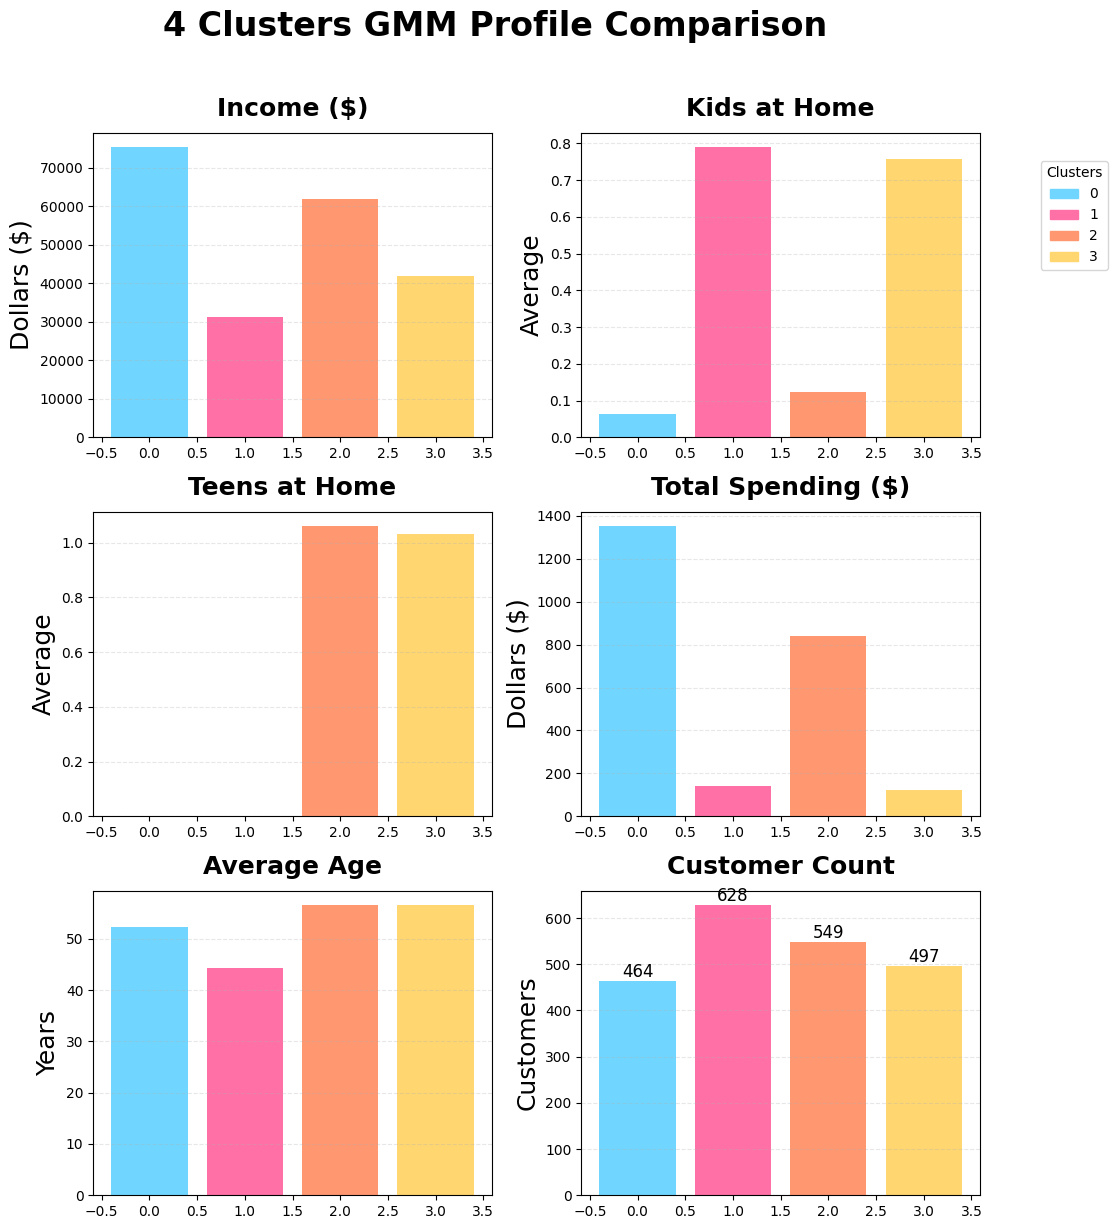

In [9]:
# Data preparation
variables = ['Income', 'Kidhome', 'Teenhome', 'Spent', 'Age', 'Count']
titles = ['Income ($)', 'Kids at Home', 'Teens at Home', 'Total Spending ($)', 'Average Age', 'Customer Count']
cluster_labels = cluster_summary.index

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle('4 Clusters GMM Profile Comparison', fontsize=24, y=1.02, weight='bold')

# Plot each variable
for ax, var, title in zip(axes.flatten(), variables, titles):
    values = cluster_summary[var]
    
    bars = ax.bar(cluster_labels, values, color=color_palette)
    ax.set_title(title, pad=12, weight='bold', fontsize=18)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add value labels for Count
    if var == 'Count':
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=12)
    
    # Format y-axis for monetary values
    if var in ['Income', 'Spent']:
        ax.set_ylabel('Dollars ($)', fontsize=18)
    elif var == 'Age':
        ax.set_ylabel('Years', fontsize=18)
    elif var == 'Count':
        ax.set_ylabel('Customers', fontsize=18)
    else:
        ax.set_ylabel('Average', fontsize=18)

plt.tight_layout()

# Add legend once
handles = [plt.Rectangle((0,0),1,1, color=color) 
           for color in color_palette]
fig.legend(handles, cluster_labels, 
           title='Clusters', 
           loc='upper right', 
           bbox_to_anchor=(1.12, 0.9))

plt.show()

In [10]:
data_scaled = read_preprocessed_data(std=False, minmax=True,gmm=True)

c:\Users\Noka9\Desktop\customer-profile-analysis\data/marketing_campaign.csv


In [11]:
 #model mieszanin gaussa

gmm = GaussianMixture(
    # Stosujemy model mieszanin gaussa dla wybranej liczby klastrów
    n_components=3,          
    covariance_type='tied',  
    # Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
    random_state=42
)
data_scaled['Cluster'] = gmm.fit_predict(data_scaled)

Text(0.5, 1.0, 'Metoda GMM dla trzech klastrów z wizualizacją PCA ')

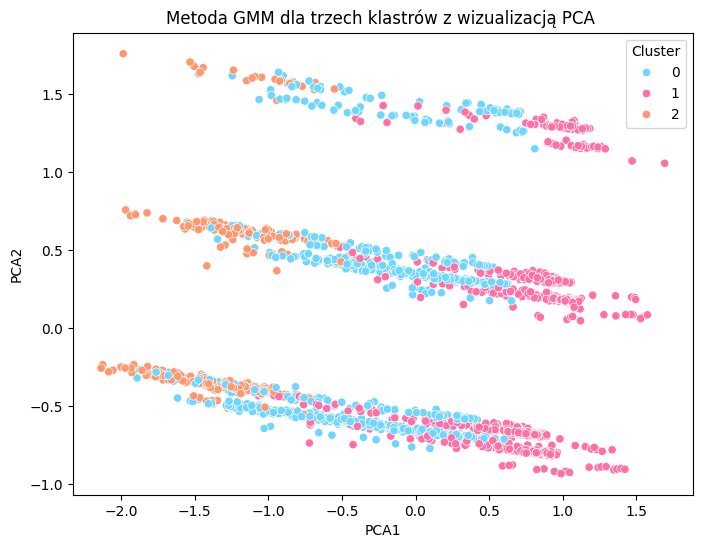

In [12]:
# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
color_palette = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_palette[:-1]
)
plt.title("Metoda GMM dla trzech klastrów z wizualizacją PCA ")

In [13]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster


#Dla łatwiejszej analizy wydatków zliczamy procent przychodów jaki stanowią wydatki (pozwala identyfikować rozrzutnych klientów)
original_data["Spending_To_Income_Ratio"] = original_data["Spent"]/original_data["Income"]
cluster_summary["Spending_To_Income_Ratio_Mode"] = original_data.groupby("Cluster")["Spending_To_Income_Ratio"].agg(lambda x: x.mode()[0])

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()
# Podsumowanie klastrów

kl1 = cluster_summary.iloc[1].values.tolist()
cluster_summary.transpose()

c:\Users\Noka9\Desktop\customer-profile-analysis\data/marketing_campaign.csv


Cluster,0,1,2
Income,54305.273465,38246.979415,77098.494318
Kidhome,0.0,1.049837,0.0
Teenhome,0.719583,0.471289,0.107955
Recency,47.967555,49.201517,51.173295
MntWines,359.77752,100.664139,600.991477
MntFruits,24.14774,7.892199,49.856534
MntMeatProducts,113.67555,46.047264,484.250355
MntFishProducts,34.143685,11.215601,80.90625
MntSweetProducts,24.093859,7.855905,52.005682
MntGoldProds,47.480881,21.340737,65.482955


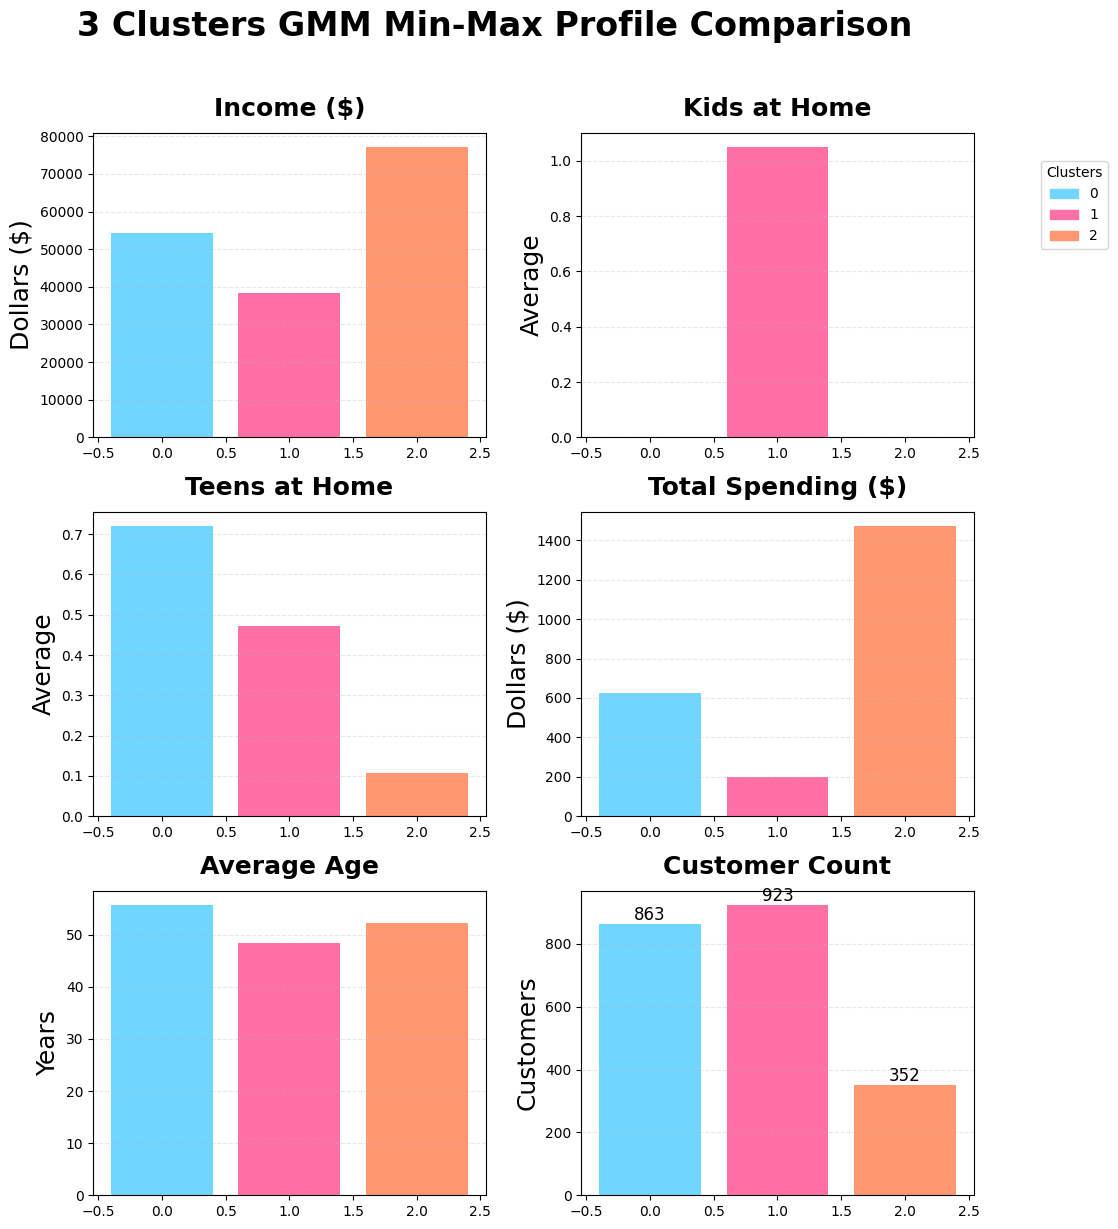

In [14]:
# Data preparation
variables = ['Income', 'Kidhome', 'Teenhome', 'Spent', 'Age', 'Count']
titles = ['Income ($)', 'Kids at Home', 'Teens at Home', 'Total Spending ($)', 'Average Age', 'Customer Count']
cluster_labels = cluster_summary.index

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle('3 Clusters GMM Min-Max Profile Comparison', fontsize=24, y=1.02, weight='bold')

# Plot each variable
for ax, var, title in zip(axes.flatten(), variables, titles):
    values = cluster_summary[var]
    
    bars = ax.bar(cluster_labels, values, color=color_palette)
    ax.set_title(title, pad=12, weight='bold', fontsize=18)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add value labels for Count
    if var == 'Count':
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=12)
    
    # Format y-axis for monetary values
    if var in ['Income', 'Spent']:
        ax.set_ylabel('Dollars ($)', fontsize=18)
    elif var == 'Age':
        ax.set_ylabel('Years', fontsize=18)
    elif var == 'Count':
        ax.set_ylabel('Customers', fontsize=18)
    else:
        ax.set_ylabel('Average', fontsize=18)

plt.tight_layout()

# Add legend once
handles = [plt.Rectangle((0,0),1,1, color=color) 
           for color in color_palette]
fig.legend(handles, cluster_labels, 
           title='Clusters', 
           loc='upper right', 
           bbox_to_anchor=(1.12, 0.9))

plt.show()

In [15]:
 #model mieszanin gaussa

gmm = GaussianMixture(
    # Stosujemy model mieszanin gaussa dla wybranej liczby klastrów
    n_components=4,          
    covariance_type='tied',  
    # Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
    random_state=42
)
data_scaled['Cluster'] = gmm.fit_predict(data_scaled)

Text(0.5, 1.0, 'Metoda GMM dla trzech klastrów z wizualizacją PCA ')

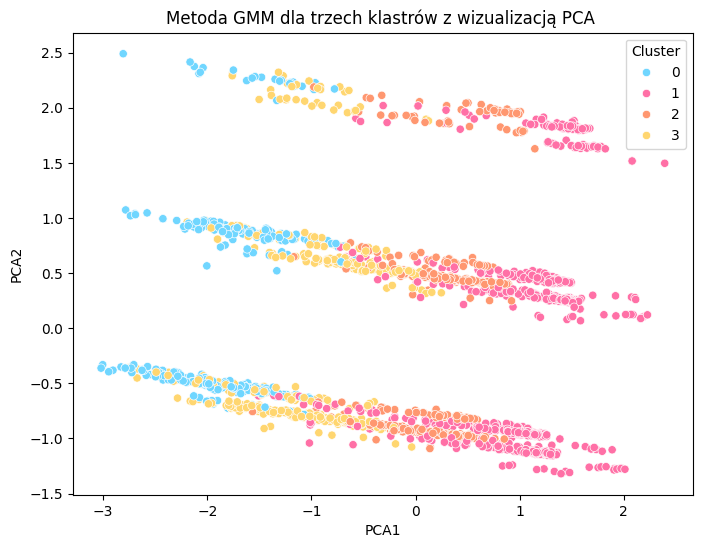

In [16]:
# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
color_palette = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_palette
)
plt.title("Metoda GMM dla trzech klastrów z wizualizacją PCA ")

In [17]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster


#Dla łatwiejszej analizy wydatków zliczamy procent przychodów jaki stanowią wydatki (pozwala identyfikować rozrzutnych klientów)
original_data["Spending_To_Income_Ratio"] = original_data["Spent"]/original_data["Income"]
cluster_summary["Spending_To_Income_Ratio_Mode"] = original_data.groupby("Cluster")["Spending_To_Income_Ratio"].agg(lambda x: x.mode()[0])

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()
# Podsumowanie klastrów

kl1 = cluster_summary.iloc[1].values.tolist()
cluster_summary.transpose()

c:\Users\Noka9\Desktop\customer-profile-analysis\data/marketing_campaign.csv


Cluster,0,1,2,3
Income,77098.494318,38246.979415,43506.688787,65382.694836
Kidhome,0.0,1.049837,0.0,0.0
Teenhome,0.107955,0.471289,0.702517,0.737089
Recency,51.173295,49.201517,48.267735,47.659624
MntWines,600.991477,100.664139,171.480549,552.93662
MntFruits,49.856534,7.892199,10.083524,38.575117
MntMeatProducts,484.250355,46.047264,49.24714,179.767606
MntFishProducts,80.90625,11.215601,15.304348,53.469484
MntSweetProducts,52.005682,7.855905,9.457666,39.107981
MntGoldProds,65.482955,21.340737,31.09611,64.288732
